# OLCI spatial plotting, quality control and data interrogation

    Version: 2.0
    Date: 03/09/2018
    Author: Ben loveday, Plymouth Marine Laboratory

This aim of this code is to introduce you to Python and to simply import a netCDF file in to your python workspace, conduct some basic operations, and plot an image. In this case, we will be using a level-2 OLCI image, but the script can be easily adapted to plot any netCDF variable.


The first step in any python code is usually to import libraries that you will need. Libraries are usually code modules that perform specific tasks or provide specific capability (e.g. statistical analysis or plotting routines). In this case we will import the netCDF library, the numpy library which will help to conduct various operations on the data, and the matplotlib plotting library to generate some images. We will also import the os library, that allows python access to some command-line-eqsue capability like 'list directory', as well as the python library that governs the reporting of warning (so that we can turn them off here, and make the code run without being so 'noisy').

In [1]:
%matplotlib inline

# libraries are imported here, and we can import any library with an alias that allows us easy access to them later.
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

Usually we also define functions at the top of a Python script. Functions are routines that can be called elsewhere in our script and perform a specific task. Typically we would use a function to take care of any process that we are going to perform more than once. The box below defines a function that will mask our data according to quality flags. We will call this function later on.

In [2]:
def flag_data_fast(flags_we_want, flag_names, flag_values, flag_data, flag_type='WQSF'):
    flag_bits = np.uint64()
    if flag_type == 'SST':
        flag_bits = np.uint8()
    elif flag_type == 'WQSF_lsb':
        flag_bits = np.uint32()
    
    for flag in flags_we_want:
        try:
            flag_bits = flag_bits | flag_values[flag_names.index(flag)]
        except:
            print(flag + " not present")
    
    return (flag_data & flag_bits) > 0

Now we will start our script, proper.

We being by seting paths to let python know where our data is stored, and what it is called. If you keep your scripts and files in the same folder, you will not need to set the full path to the data file. However you may want to store things in different places and so it is good practice to be specific. The first line in this box gets us the path where this file is.

In [3]:
input_root    = "/Users/jconchas/Documents/Research/Sentinel_3"
input_path    = 'S3A_OL_2_WFR____20181005T004814_20181005T005114_20181006T095137_0179_036_259_2160_MAR_O_NT_002.SEN3'
file_name_chl = 'chl_nn.nc'

We read the file using functions from the netCDF4 (alias "nc") library. Note that to use a library in python you use the imported alias followed by a dot, and then the function you want (e.g. nc.Dataset).

In [4]:
OLCI_file     =  nc.Dataset(os.path.join(input_root,input_path,file_name_chl), 'r')

To access a variable you can use the following command, where the name of the variable you are interested in, follows the hash. If you remove the hash in the following box, put the cursor after the dot and hit 'tab' you will be presented with a list of all of the variables and methods associated with the OLCI_file object. Python is an 'object orientatated' language, which means that all objects have relevant methods associated with them. 

note: If you want to run all this code in one go, remember to put the hash back at the start of this line beforehand.

In [5]:
#OLCI_file.

So, lets load in some data...

In [6]:
CHL     = OLCI_file.variables['CHL_NN'][:].data
fillval = OLCI_file.variables['CHL_NN']._FillValue

# check where chl is equal to fill value and set it to 'no data', e.g. nan. 
# This is the simplest masking we can do to our data. More complex masking 
# is shown later on.
CHL[CHL == fillval] = np.nan

You can look at the variables in your workspace in interactive python 
environments (like this, or ipython) by typing 'whos'. This will tell you the name of the variable, it's type and then information on it, such as its size and shape. 

In [7]:
whos

Variable         Type        Data/Info
--------------------------------------
CHL              ndarray     4090x4865: 19897850 elems, type `float32`, 79591400 bytes (75.9042739868164 Mb)
OLCI_file        Dataset     <class 'netCDF4._netCDF4.<...>,columns)\n    groups: \n
file_name_chl    str         chl_nn.nc
fillval          uint8       255
flag_data_fast   function    <function flag_data_fast at 0x112351840>
input_path       str         S3A_OL_2_WFR____20181005T<...>59_2160_MAR_O_NT_002.SEN3
input_root       str         /Users/jconchas/Documents/Research/Sentinel_3
nc               module      <module 'netCDF4' from '/<...>ges/netCDF4/__init__.py'>
np               module      <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
os               module      <module 'os' from '/Users<...>nda/lib/python3.5/os.py'>
plt              module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
warnings         module      <module 'warnings' from '<...>b/python3.5/warnings.py'>


Lets take a look at our data..

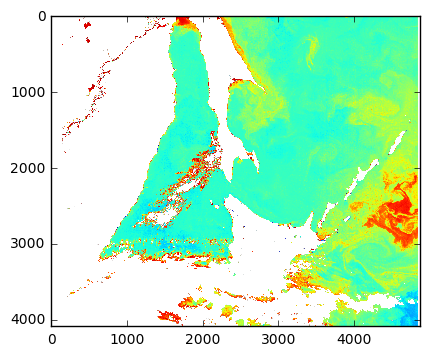

In [8]:
plt.imshow(CHL);

This is not the prettiest plot - Python can do much better. For a start, we may wish to look at a smaller area. We'll do this now, using the relevant indexes for area of data you wish to use. 



In [9]:
row1=1000
row2=1500
col1=2000
col2=2500
CHL_subset = CHL[row1:row2, col1:col2]

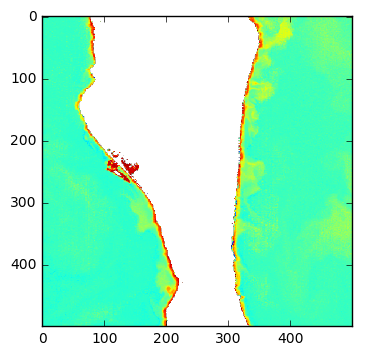

In [10]:
plt.imshow(CHL_subset);

You will notice a few problems with displaying plots like this. Firstly - they don't look very pretty (the colour scheme is not ideal, it is hard to see the coastline, and you can't differentiate the land from cloud), and secondly - the axes don't provide any information on the location (other than within the array) and there is no colour bar. 

To make a better plot we will need to add a few more tools to the libraries/modules we've currently imported. Below are a few lines of code to import cartopy (which will help us make a better, map based plot) and a few other tools to tweak how the data is displayed. 

The Cartopy is module allows us to use map projections to display data in a geographically relevant way. For those that are familiar to python, Cartopy has largely replaced the Basemap library.


In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

We will also need to load other data to make the plot - the longitude and latitude data associated with each pixel of the chlorophyll data. This data can be found in the geo_coordinates.nc file, within each S3 OLCI L2 folder. We load this in a very similar way to how we loaded the chlorophyll data, just with different file and variable names. The data path remains the same, referring the folder that contains all the netcdf files.


In [12]:
file_name_geo = 'geo_coordinates.nc'
# NOTE THAT I HAVE DONE A 'TIE-POINT EXPANSION' HERE TO GET FULL LAT/LON VARIABLES. THIS CAN BE DONE IN SNAP.
GEO_file      = nc.Dataset(os.path.join(input_root,input_path,file_name_geo), 'r')
LAT           = GEO_file.variables['latitude'][:]
LON           = GEO_file.variables['longitude'][:]
LAT_subset    = LAT[row1:row2, col1:col2]
LON_subset    = LON[row1:row2, col1:col2]
GEO_file.close()

Then we need to initialise the map we will use for plotting. The important things to choose here are:

1. the projection you wish to use (this may depend on your region of interest, particularly if you are looking at polar data, more information about the different projects is available here: https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html)
2. The limits of your map (by default, this will be set to your data limits)
3. The resolution of the map coastline.

See more information about the options for Cartopy here: https://scitools.org.uk/cartopy/docs/latest/

(If you don't have basemap installed, you can type "conda install -c scitools/label/archive cartopy" in your command prompt, with the anaconda distribution).

We start by defining a figure (line 1 below) and then defining a map projection (line 2). All mapping instructions are taken care of using our map object 'm'. Now we make the plot (this may take some time to draw!)

You can also save the figure using the code below (this will save in the folder where you are running the code, if you want to save elsewhere you need to specify the path).


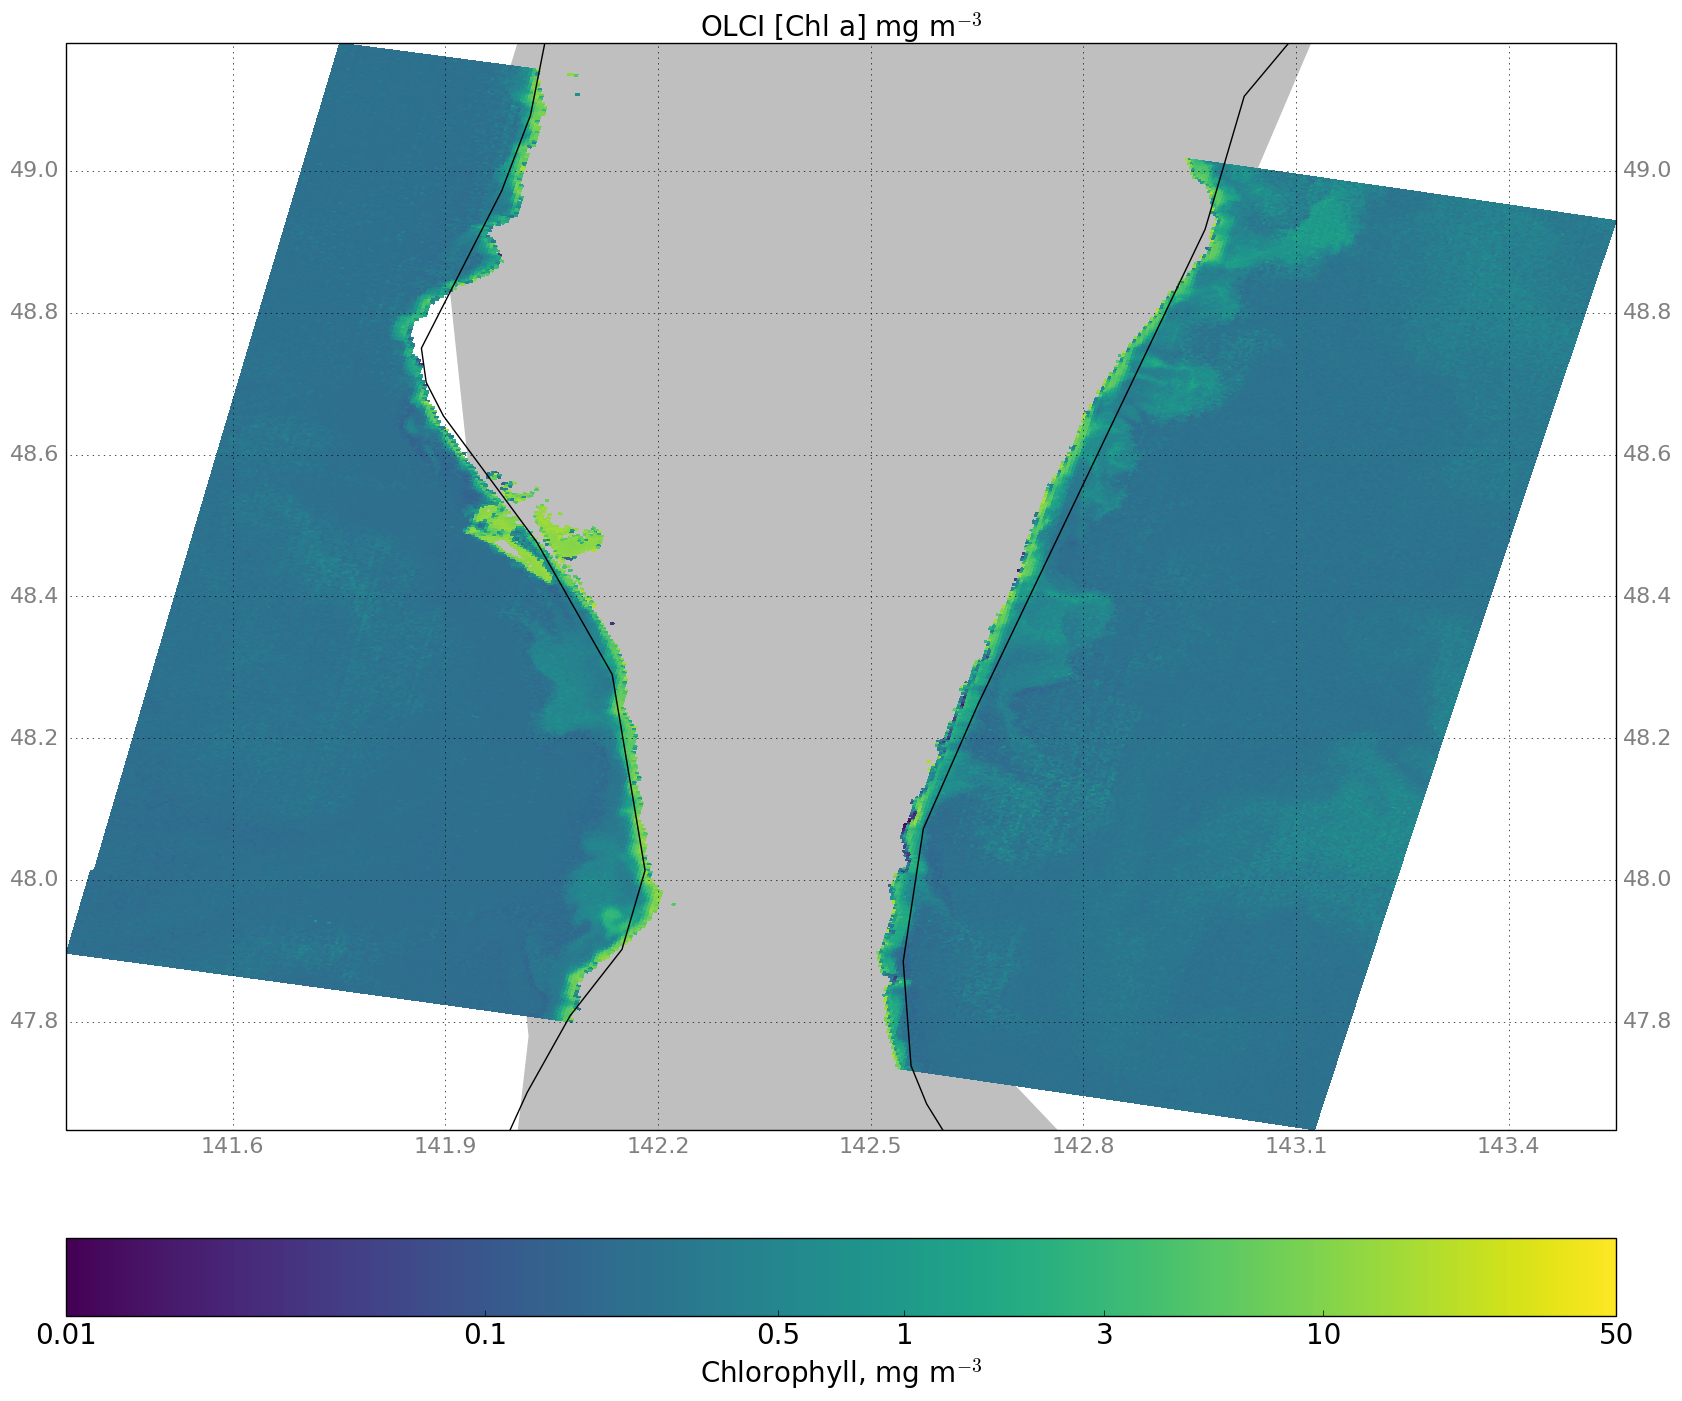

In [13]:
fig2 = plt.figure(figsize=(20, 20), dpi=300)
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
f1 = plt.pcolor(LON_subset,LAT_subset,np.ma.masked_invalid(CHL_subset), shading='flat', vmin=np.log10(0.01), vmax=np.log10(50), cmap=plt.cm.viridis)  
m.coastlines(resolution='50m', color='black', linewidth=1)
m.add_feature(cfeature.LAND, facecolor='0.75')
g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07, ticks=[np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(3),np.log10(10),np.log10(50)]) 
cbar.ax.set_xticklabels(['0.01','0.1','0.5','1','3','10','50'], fontsize=20) 
cbar.set_label('Chlorophyll, mg m$^{-3}$', fontsize=20)
plt.title('OLCI [Chl a] mg m$^{-3}$', fontsize=20);
plt.show()

In [ ]:
fig1 = plt.figure(figsize=(20, 20), dpi=300)
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
f1 = plt.pcolor(LON, LAT, np.ma.masked_invalid(CHL), shading='flat', vmin=np.log10(0.01), vmax=np.log10(50), cmap=plt.cm.viridis)
m.coastlines(resolution='50m', color='black', linewidth=1)
m.add_feature(cfeature.LAND, facecolor='0.75')
g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07, ticks=[np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(3),np.log10(10),np.log10(50)]) 
cbar.ax.set_xticklabels(['0.01','0.1','0.5','1','3','10','50'], fontsize=20) 
cbar.set_label('Chlorophyll, mg m$^{-3}$', fontsize=20)
plt.title('OLCI [Chl a] mg m$^{-3}$', fontsize=20);
plt.show()

In [14]:
fig2.savefig('OLCI_CHL_spatial_demo_no_flags.png', bbox_inches='tight')

However, this data is not flag masked. This means that we may have data that is subject to glint, or cloud, or a variety of other conditions that variously undermine quality. So, lets apply some flags. We are going to flag extensively, removing all data that corresponds to the following conditions...

In [15]:
flags_we_want = ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT',
                 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL', 'WHITECAPS', 'ANNOT_ABSO_D', 'ANNOT_MIXR1',
                 'ANNOT_DROUT', 'ANNOT_TAU06', 'RWNEG_O2', 'RWNEG_O3', 'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6',
                 'RWNEG_O7', 'RWNEG_O8']

file_name_flags = 'wqsf.nc'
FLAG_file = nc.Dataset(os.path.join(input_root,input_path,file_name_flags), 'r')
# get all the flag names
flag_names = FLAG_file['WQSF'].flag_meanings.split(' ')
# get all the flag bit values
flag_vals = FLAG_file['WQSF'].flag_masks
# get the flag field itself
FLAGS = FLAG_file.variables['WQSF'][:]
# make the flag mask using the function we defined above "flag_data_fast"
flag_mask = flag_data_fast(flags_we_want, flag_names, flag_vals, FLAGS, flag_type='WQSF')
flag_mask = flag_mask.astype(float)
flag_mask[flag_mask == 0.0] = np.nan

# subset the flag mask
FLAG_subset = flag_mask[row1:row2, col1:col2]

And now we apply the flag data to our data and plot again...

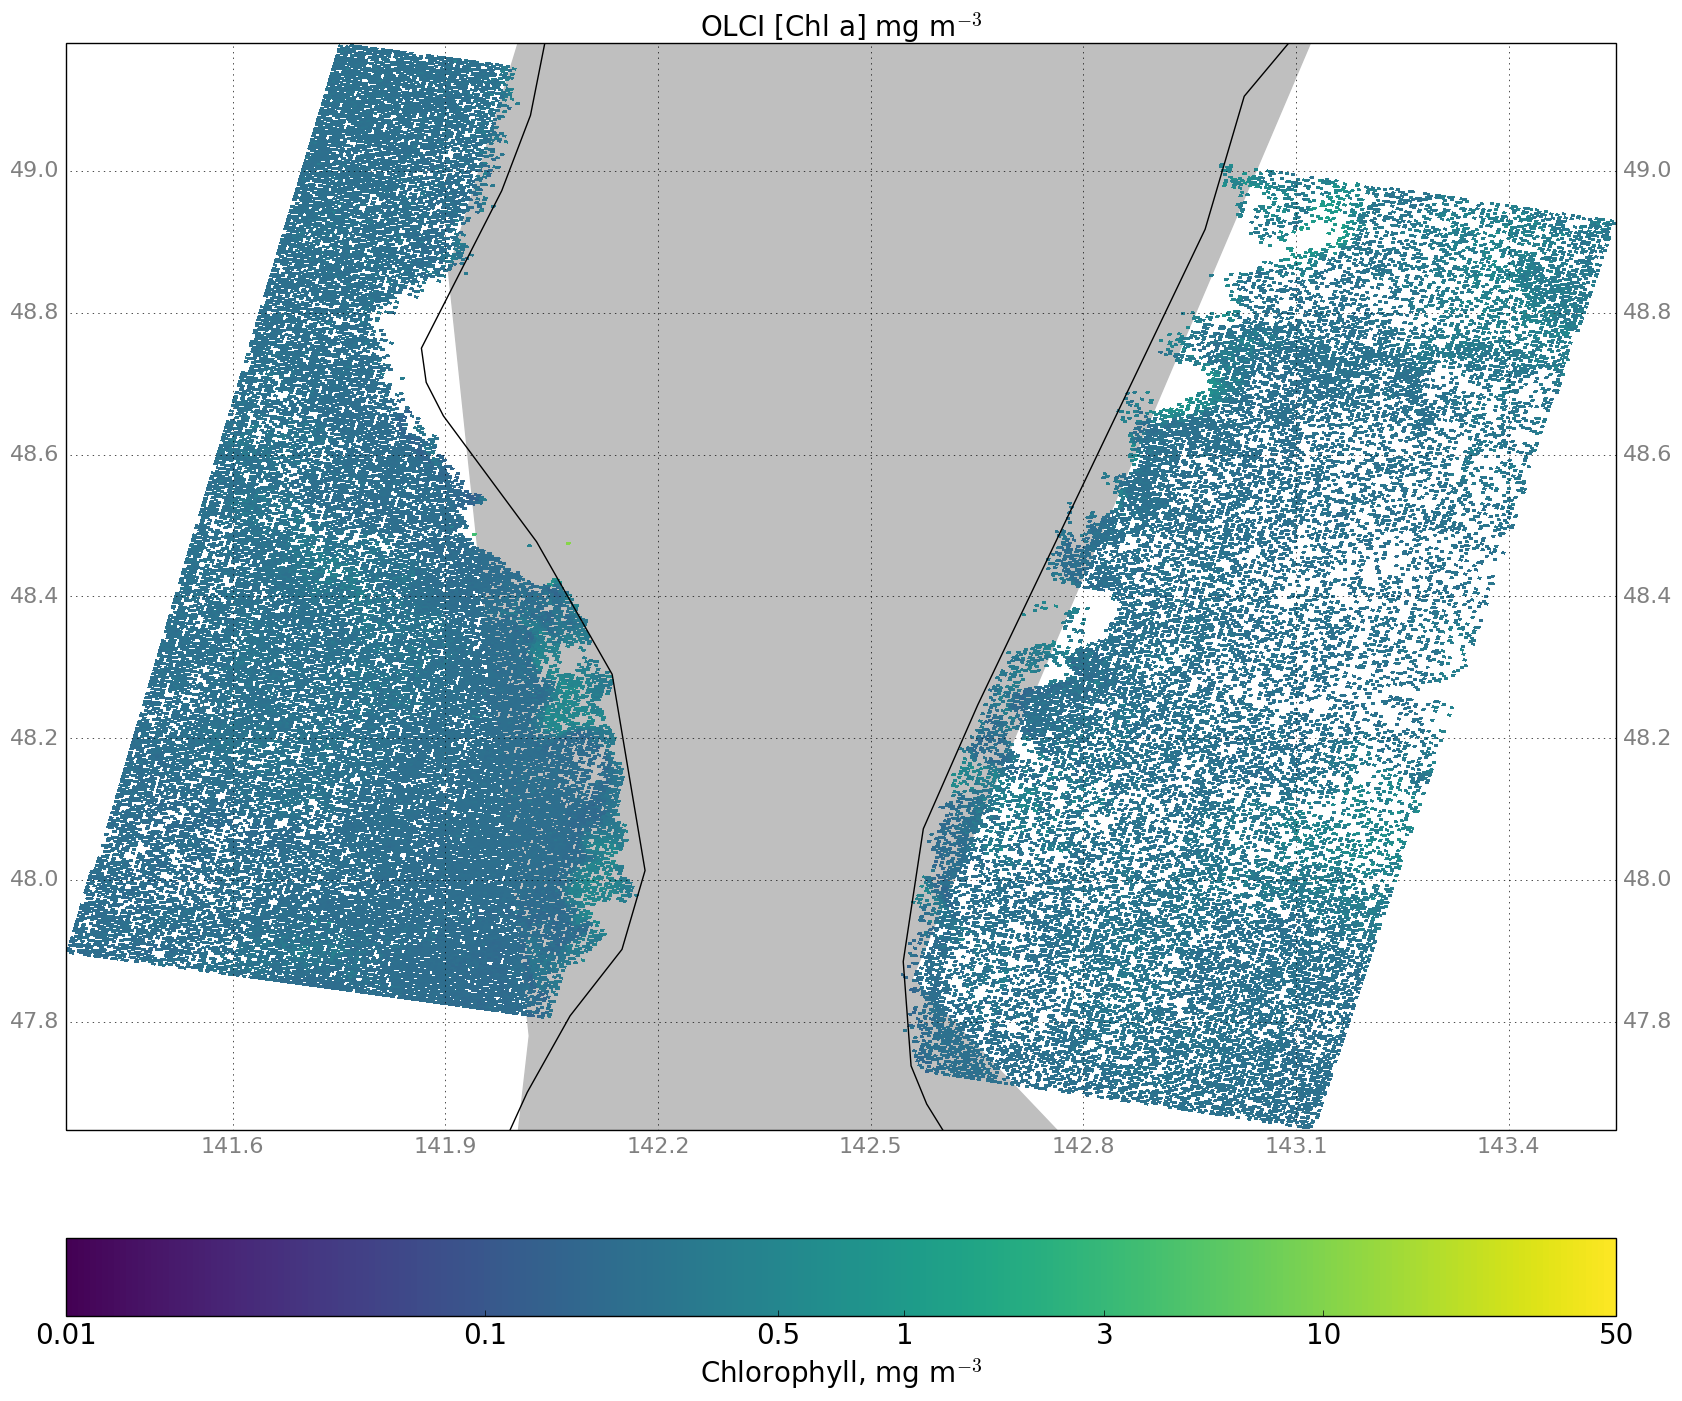

In [17]:
CHL_subset[np.isfinite(FLAG_subset)] = np.nan

fig3 = plt.figure(figsize=(20, 20), dpi=300)
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
f1 = plt.pcolor(LON_subset,LAT_subset,np.ma.masked_invalid(CHL_subset), shading='flat', vmin=np.log10(0.01), vmax=np.log10(50), cmap=plt.cm.viridis)  
m.coastlines(resolution='50m', color='black', linewidth=1)
m.add_feature(cfeature.LAND, facecolor='0.75')
g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07, ticks=[np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(3),np.log10(10),np.log10(50)]) 
cbar.ax.set_xticklabels(['0.01','0.1','0.5','1','3','10','50'], fontsize=20) 
cbar.set_label('Chlorophyll, mg m$^{-3}$', fontsize=20)
plt.title('OLCI [Chl a] mg m$^{-3}$', fontsize=20);
plt.show()

In [18]:
fig3.savefig('OLCI_CHL_spatial_demo_flags.png', bbox_inches='tight')

The flags_we_want variable can be customised to any flag combination required, and, if you wish, the box above can be adapted to plog flags instead of the CHL field. You could also run the flags_we_want routine with each flag individially, to get a mask for every flag. That can then be used in more advanced plotting. But thats up to you...